## Import libraries

In [1]:

import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
import re
import os
import time
import math



### constants to sync with values in d435-capture.ipynb



In [2]:
depth_scale = 9.999999747378752e-05
#imgfolder = "D:/d435/manu-bear-20181027/"
imgfolder = "D:/d435/puzzle-box-848-20181027/"

width = 848
height = 480


### fetch all file names


In [3]:
filelist = sorted(os.listdir(imgfolder))

# ['c_1540534762479.1584.npy', 'c_1540534762645.808.npy', 'c_1540534762813.2444.npy', 
#  'd_1540534762479.1584.npy', 'd_1540534762645.808.npy', 'd_1540534762813.2444.npy']
#print(filelist)

timesteps = []
filetimes = []
color_files = []
depth_files = []
base_time = -1.0

for f in filelist:
    result = re.search('c_(.*).npy', f)
    if result and result.group(1):
        t = result.group(1)
        timesteps.append(float(t))
        if base_time < 0:
            base_time = float(t)
        filetimes.append(t)
        color_files.append(f)
        depth_files.append("d_" + t + ".npy")

#print(timesteps)
#print(depth_files)
print(len(depth_files))

997


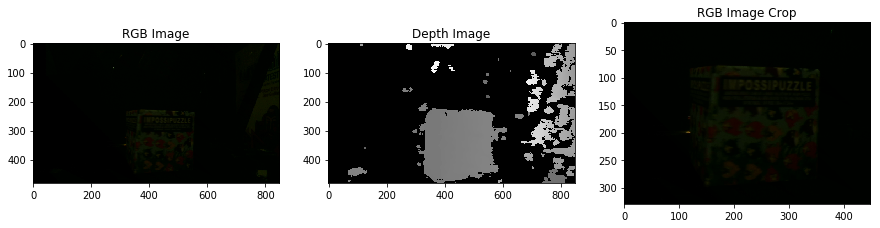

In [5]:
color_image = np.load(imgfolder + color_files[10])
depth_image = np.load(imgfolder + depth_files[10])


# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(depth_image, cmap='gray')

cimage = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
table3 = fig.add_subplot(1,3,3)
table3.set_title("RGB Image Crop")
table3.imshow(cimage[150:,200:648,:])


In [6]:
print(depth_image.shape)
print(depth_image[450,600])
print(depth_image[450,600]*depth_scale)

print(color_image.shape)
print(color_image[450,600])

max_depth = int(0.5/depth_scale)
print("Max Depth Int ",max_depth)

min_depth = int(0.2/depth_scale)
print("Min Depth Int ",min_depth)

(480, 848)
0
0.0
(480, 848, 3)
[0 2 0]
Max Depth Int  5000
Min Depth Int  2000


In [13]:
radian_size = 6283
h_fov = 69.4*math.pi/180
# the tangent constant for the FOV/2 of the camera
fov_tan = math.tan(h_fov/2)
print("fov tan",fov_tan)
print("depth scale",depth_scale)
# distance between turntable center and camera
# Sony turntable distance = 31cm
turn_dist = 0.31

# 33.33 rpm = 3.49065846509342 rad/s
rotate_speed = 3.49065846509342

cylinder_depth = np.zeros((720,radian_size), dtype=float)
cylinder_count = np.zeros((720,radian_size), dtype=int)
cylinder_r = np.zeros((720,radian_size), dtype=float)
cylinder_g = np.zeros((720,radian_size), dtype=float)
cylinder_b = np.zeros((720,radian_size), dtype=float)


#    x′ = x cos ⁡ θ − y sin ⁡ θ
#    y′ = x sin ⁡ θ + y cos ⁡ θ
point_count = 0
max_coord = 0
min_coord = 1000000

#for n in range(len(depth_files)):
for n in range(len(depth_files)):
    print("Processing ",n," file ",color_files[n])
    color_image = np.load(imgfolder + color_files[n])
    depth_image = np.load(imgfolder + depth_files[n])
    # timedelta is in seconds
    time_delta = (timesteps[n] - base_time)/1000
    angle_delta = (time_delta * rotate_speed) % (2*math.pi)
    print(angle_delta)
    #print(depth_image[450,180])
    for x in range(200,width-200):
        for z in range(150,height):
            y = depth_image[z,x]
            if max_coord < y:
                max_coord = y
            if min_coord > y:
                min_coord = y

            r = color_image[z,x,2]
            g = color_image[z,x,1]
            b = color_image[z,x,0]
            # cam_y is in metres
            cam_y = y * depth_scale
            if cam_y < 0.05:
                continue
            if cam_y > (turn_dist*1.4):
                continue
            # x in camera coord
            cam_x = ((x - (width/2))/(width/2)) * cam_y *  fov_tan
            # convert to center of turntable coordinates
            turn_x = cam_x
            turn_y = cam_y - turn_dist
            # rotate by angle_delta
            rot_x = turn_x * math.cos(angle_delta) - turn_y * math.sin(angle_delta)
            rot_y = turn_x * math.sin(angle_delta) + turn_y * math.cos(angle_delta)            
            # rot_radius = depth is now distance from the turntable center
            # rot_angle is between -pi and pi
            rot_radius = math.sqrt(rot_x*rot_x + rot_y*rot_y)
            rot_angle = math.atan2(rot_y, rot_x)
            rot_coord = int(radian_size * (rot_angle + math.pi)/(2*math.pi))
            # record into the arrays
            if cylinder_count[z, rot_coord] > 0:
                count = cylinder_count[z, rot_coord]
                cylinder_depth[z, rot_coord] = ((cylinder_depth[z, rot_coord] * count) + rot_radius) / (count + 1)
                cylinder_r[z, rot_coord] = ((cylinder_r[z, rot_coord] * count) + r) / (count + 1)
                cylinder_g[z, rot_coord] = ((cylinder_g[z, rot_coord] * count) + g) / (count + 1)
                cylinder_b[z, rot_coord] = ((cylinder_b[z, rot_coord] * count) + b) / (count + 1)
            else:
                cylinder_depth[z, rot_coord] = rot_radius
                cylinder_r[z, rot_coord] = r
                cylinder_g[z, rot_coord] = g
                cylinder_b[z, rot_coord] = b
            cylinder_count[z, rot_coord] += 1
            #if max_coord < rot_coord:
            #    max_coord = rot_coord
            #if min_coord > rot_coord:
            #    min_coord = rot_coord
            point_count += 1
    print("Point count", point_count)
    point_count = 0
            
print("Done")
#print("Point count", point_count)
#print("Max Min ", max_coord, " ", min_coord)

fov tan 0.69243282809315
depth scale 9.999999747378752e-05
Processing  0  file  c_1540627635557.1392.npy
0.0
Point count 59383
Processing  1  file  c_1540627635590.236.npy
0.11553005732919665
Point count 59524
Processing  2  file  c_1540627635624.1655.npy
0.23396615600750675
Point count 62953
Processing  3  file  c_1540627635657.5002.npy
0.35032626737601025
Point count 55383
Processing  4  file  c_1540627635724.8257.npy
0.5853363825191956
Point count 53133
Processing  5  file  c_1540627635758.4229.npy
0.7026126212924783
Point count 57172
Processing  6  file  c_1540627635791.79.npy
0.8190860767957125
Point count 61760
Processing  7  file  c_1540627635825.425.npy
0.9364944083575912
Point count 55461
Processing  8  file  c_1540627635859.196.npy
1.0543774217468764
Point count 52372
Processing  9  file  c_1540627635892.6619.npy
1.171195170712
Point count 52134
Processing  10  file  c_1540627635926.277.npy
1.2885344731391932
Point count 58577
Processing  11  file  c_1540627635959.7087.npy
1.

Point count 60219
Processing  99  file  c_1540627639017.3052.npy
5.79507248589039
Point count 60062
Processing  100  file  c_1540627639050.7405.npy
5.911783708413099
Point count 60742
Processing  101  file  c_1540627639084.5237.npy
6.029709332379349
Point count 63779
Processing  102  file  c_1540627639117.7107.npy
6.145553855766559
Point count 58290
Processing  103  file  c_1540627639151.7908.npy
6.264515768964635
Point count 53069
Processing  104  file  c_1540627639185.1755.npy
0.0978652765191157
Point count 51373
Processing  105  file  c_1540627639218.942.npy
0.2157320978891537
Point count 54925
Processing  106  file  c_1540627639252.5042.npy
0.332886470412312
Point count 59304
Processing  107  file  c_1540627639285.8708.npy
0.4493582214924672
Point count 56501
Processing  108  file  c_1540627639319.6172.npy
0.5671551615162809
Point count 50821
Processing  109  file  c_1540627639353.1602.npy
0.6842422093278326
Point count 51071
Processing  110  file  c_1540627639386.8982.npy
0.802010

Point count 57834
Processing  197  file  c_1540627642780.2075.npy
0.08052348388243757
Point count 54636
Processing  198  file  c_1540627642814.1528.npy
0.19901497631080645
Point count 51676
Processing  199  file  c_1540627642847.3955.npy
0.31505380392898275
Point count 49827
Processing  200  file  c_1540627642881.0095.npy
0.43238884529847965
Point count 62961
Processing  201  file  c_1540627642914.486.npy
0.5492440915713317
Point count 63719
Processing  202  file  c_1540627642948.192.npy
0.6668995644796176
Point count 60002
Processing  203  file  c_1540627642981.862.npy
0.7844306145031616
Point count 63776
Processing  204  file  c_1540627643015.278.npy
0.9010745123142598
Point count 56964
Processing  205  file  c_1540627643048.7148.npy
1.017790848106202
Point count 54614
Processing  206  file  c_1540627643082.817.npy
1.1368294603428204
Point count 56860
Processing  207  file  c_1540627643116.0312.npy
1.2527694314224362
Point count 51943
Processing  208  file  c_1540627643149.4585.npy
1

Point count 51274
Processing  295  file  c_1540627646341.3809.npy
6.22817804109345
Point count 58121
Processing  296  file  c_1540627646375.186.npy
0.06299505691865193
Point count 58304
Processing  297  file  c_1540627646408.4404.npy
0.17907479069071286
Point count 64650
Processing  298  file  c_1540627646442.5444.npy
0.2981202206196514
Point count 62363
Processing  299  file  c_1540627646475.8433.npy
0.41435505689187124
Point count 60954
Processing  300  file  c_1540627646509.203.npy
0.5308020938373801
Point count 60242
Processing  301  file  c_1540627646543.361.npy
0.6500367147280457
Point count 55268
Processing  302  file  c_1540627646576.576.npy
0.7659783902307353
Point count 53142
Processing  303  file  c_1540627646610.6406.npy
0.8848866141018377
Point count 52031
Processing  304  file  c_1540627646643.9365.npy
1.0011112238355864
Point count 57257
Processing  305  file  c_1540627646677.591.npy
1.1185877323206128
Point count 57191
Processing  306  file  c_1540627646744.3523.npy
1.3

Point count 51363
Processing  393  file  c_1540627650238.8433.npy
0.9833322466792396
Point count 53142
Processing  394  file  c_1540627650272.2773.npy
1.1000392081442456
Point count 55571
Processing  395  file  c_1540627650306.1008.npy
1.2181054470144872
Point count 58152
Processing  396  file  c_1540627650339.981.npy
1.3363693989618497
Point count 62446
Processing  397  file  c_1540627650373.2212.npy
1.4523997044646322
Point count 59278
Processing  398  file  c_1540627650411.6072.npy
1.5863920725818659
Point count 59258
Processing  399  file  c_1540627650440.2986.npy
1.6865439726838645
Point count 55211
Processing  400  file  c_1540627650473.8955.npy
1.8038193592456082
Point count 51921
Processing  401  file  c_1540627650507.6567.npy
1.9216682841733146
Point count 52952
Processing  402  file  c_1540627650541.1064.npy
2.0384297871768453
Point count 54978
Processing  403  file  c_1540627650574.7715.npy
2.1559429407580666
Point count 61809
Processing  404  file  c_1540627650608.3677.npy


Point count 59235
Processing  491  file  c_1540627653799.9812.npy
0.8476779260374485
Point count 64092
Processing  492  file  c_1540627653833.6052.npy
0.9650479080800594
Point count 61965
Processing  493  file  c_1540627653867.2825.npy
1.0826036722382426
Point count 59244
Processing  494  file  c_1540627653900.8904.npy
1.1999174083192656
Point count 61373
Processing  495  file  c_1540627653934.48.npy
1.317167228534828
Point count 57959
Processing  496  file  c_1540627653967.8015.npy
1.4334813204802117
Point count 51202
Processing  497  file  c_1540627654001.4614.npy
1.550976577619096
Point count 55222
Processing  498  file  c_1540627654035.0627.npy
1.668267303988543
Point count 58997
Processing  499  file  c_1540627654068.6504.npy
1.7855103065117817
Point count 57078
Processing  500  file  c_1540627654102.622.npy
1.9040938377864052
Point count 52455
Processing  501  file  c_1540627654136.2683.npy
2.0215413710790955
Point count 52558
Processing  502  file  c_1540627654170.3584.npy
2.140

Point count 58591
Processing  589  file  c_1540627657260.736.npy
0.3616206389811225
Point count 64235
Processing  590  file  c_1540627657293.9568.npy
0.47758276756076157
Point count 62328
Processing  591  file  c_1540627657328.134.npy
0.596883860951479
Point count 62419
Processing  592  file  c_1540627657361.4736.npy
0.7132610165507742
Point count 61672
Processing  593  file  c_1540627657394.8484.npy
0.8297608906117233
Point count 56848
Processing  594  file  c_1540627657429.1133.npy
0.949367927945076
Point count 53034
Processing  595  file  c_1540627657462.2507.npy
1.0650394523897972
Point count 51408
Processing  596  file  c_1540627657495.3848.npy
1.1806990458729842
Point count 55477
Processing  597  file  c_1540627657529.1692.npy
1.2986289308969248
Point count 59462
Processing  598  file  c_1540627657562.824.npy
1.4161062915934934
Point count 51882
Processing  599  file  c_1540627657596.9563.npy
1.5352505780609818
Point count 53651
Processing  600  file  c_1540627657663.5525.npy
1.7

Point count 59730
Processing  687  file  c_1540627661258.6304.npy
1.7505335604689094
Point count 62576
Processing  688  file  c_1540627661292.282.npy
1.8679998424154718
Point count 57459
Processing  689  file  c_1540627661326.4087.npy
1.98712452801756
Point count 55427
Processing  690  file  c_1540627661359.5105.npy
2.102671629577543
Point count 53913
Processing  691  file  c_1540627661393.4263.npy
2.221060004409651
Point count 57729
Processing  692  file  c_1540627661426.5508.npy
2.3366863616427906
Point count 60121
Processing  693  file  c_1540627661460.0493.npy
2.4536183069541835
Point count 58415
Processing  694  file  c_1540627661494.041.npy
2.5722717195750135
Point count 49949
Processing  695  file  c_1540627661527.27.npy
2.6882628233469887
Point count 52965
Processing  696  file  c_1540627661560.6619.npy
2.8048223522156945
Point count 54959
Processing  697  file  c_1540627661594.964.npy
2.924559777914567
Point count 61281
Processing  698  file  c_1540627661628.8872.npy
3.0429737

Point count 57498
Processing  785  file  c_1540627665357.6777.npy
3.492537323566296
Point count 60188
Processing  786  file  c_1540627665390.86.npy
3.6083656549342606
Point count 52815
Processing  787  file  c_1540627665424.6045.npy
3.7261557772657596
Point count 54672
Processing  788  file  c_1540627665458.4607.npy
3.8443362124822613
Point count 51523
Processing  789  file  c_1540627665492.3047.npy
3.962474037121808
Point count 59758
Processing  790  file  c_1540627665525.7837.npy
4.079337805510065
Point count 63784
Processing  791  file  c_1540627665558.6956.npy
4.194221886492443
Point count 60295
Processing  792  file  c_1540627665592.6147.npy
4.312622192286113
Point count 57449
Processing  793  file  c_1540627665626.4497.npy
4.430728485098683
Point count 59972
Processing  794  file  c_1540627665659.735.npy
4.546916449736244
Point count 55257
Processing  795  file  c_1540627665693.2166.npy
4.6637887402398945
Point count 51875
Processing  796  file  c_1540627665726.8596.npy
4.7812251

Point count 54401
Processing  883  file  c_1540627669422.528.npy
5.115170964138272
Point count 63436
Processing  884  file  c_1540627669456.0388.npy
5.232145520026634
Point count 63577
Processing  885  file  c_1540627669489.7837.npy
5.3499373467812035
Point count 59948
Processing  886  file  c_1540627669523.1704.npy
5.466478979207594
Point count 61627
Processing  887  file  c_1540627669556.6785.npy
5.5834441607690195
Point count 55749
Processing  888  file  c_1540627669590.3347.npy
5.700926634734827
Point count 53559
Processing  889  file  c_1540627669624.1487.npy
5.818959637355007
Point count 52834
Processing  890  file  c_1540627669657.541.npy
5.935520870646826
Point count 49221
Processing  891  file  c_1540627669691.164.npy
6.052887443843247
Point count 59994
Processing  892  file  c_1540627669724.7751.npy
6.170212258674269
Point count 58218
Processing  893  file  c_1540627669758.3054.npy
0.0040696843062093535
Point count 50964
Processing  894  file  c_1540627669791.9097.npy
0.12137

Point count 53553
Processing  981  file  c_1540627673152.054.npy
5.567301429768179
Point count 55022
Processing  982  file  c_1540627673185.7998.npy
5.685096665368917
Point count 60314
Processing  983  file  c_1540627673219.173.npy
5.801591426160627
Point count 53399
Processing  984  file  c_1540627673252.5193.npy
5.917991591471491
Point count 49274
Processing  985  file  c_1540627673286.7173.npy
6.037365122843056
Point count 53234
Processing  986  file  c_1540627673320.3564.npy
6.154787942001093
Point count 61457
Processing  987  file  c_1540627673353.742.npy
6.2713253133698
Point count 59131
Processing  988  file  c_1540627673387.1528.npy
0.10476600755897181
Point count 63662
Processing  989  file  c_1540627673421.041.npy
0.2230580824871211
Point count 64985
Processing  990  file  c_1540627673454.3037.npy
0.3391667914515395
Point count 57047
Processing  991  file  c_1540627673487.807.npy
0.45611492878217774
Point count 53521
Processing  992  file  c_1540627673521.8303.npy
0.574879128

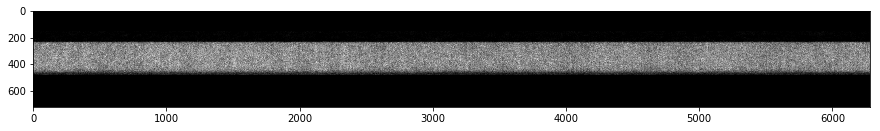

In [14]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_count, cmap='gray')
plt.show()


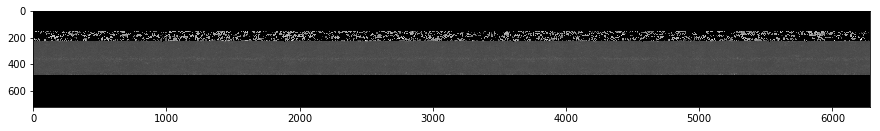

In [15]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_depth, cmap='gray')
plt.show()


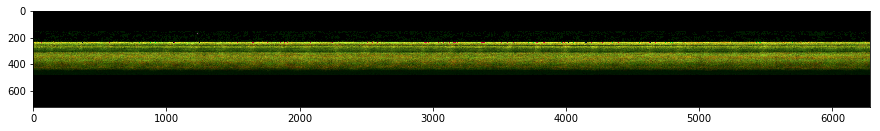

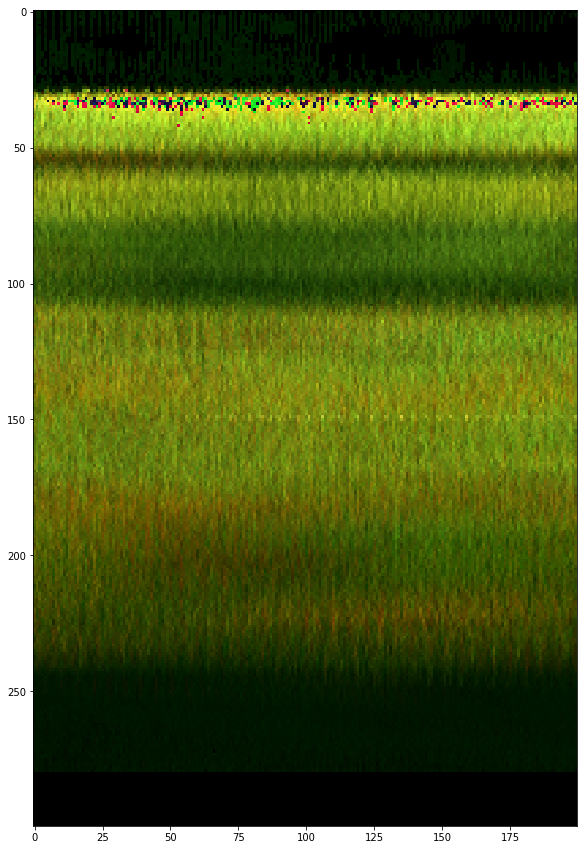

In [18]:
rgbArray = np.zeros((720,radian_size,3), 'uint8')
rgbArray[..., 0] = cylinder_r*10
rgbArray[..., 1] = cylinder_g*10
rgbArray[..., 2] = cylinder_b*10

fig = plt.figure(figsize=(15, 15))
plt.imshow(rgbArray)
plt.show()

fig = plt.figure(figsize=(15, 15))
plt.imshow(rgbArray[200:500,1000:1200,:])
plt.show()
